<a id='top'></a>
<img align="center" src="https://africanminingmarket.com/wp-content/uploads/2020/08/gold_mining.jpg" width="200" />
<p style="text-align: center;">
    <font size='5' type='bold'>
        <b>Оптимизация золотодобывающего производства</b>
    </font>
</p>

### Содержание

<a href='#section_0'>Описание проекта</a>

<a href='#section_1'>1. Подготовка данных</a>

<a href='#section_1_1'>1.1. Изучение данных</a>

<a href='#section_1_2'>1.2. Проверка расчета эффективности обогащения</a>

<a href='#section_1_3'>1.3. Анализ признаков, недоступных в тестовой выборке</a>

<a href='#section_1_4'>1.4. Предобработка данных</a>

<a href='#section_2'>2. Анализ данных</a>

<a href='#section_2_1'>2.1. Вариативность концентрации металлов (Au, Ag, Pb) на различных этапах очистки</a>

<a href='#section_2_2'>2.2. Распределение размеров гранул сырья на обучающей и тестовой выборках</a>

<a href='#section_3'>3. Модель</a>

<a href='#section_3_1'>3.1. Функция для вычисления итоговой метрики качества sMAPE</a>

<a href='#section_3_2'>3.2. Обучение и оценка качества моделей кросс-валидацией. Выбор лучшей модели</a>
* Поиск лучших параметров для тестовой выборки по сырью
* Поиск лучших параметров для тестовой выборки по финальному концентрату
    
<a href='#section_4'>Общий вывод</a>

<a href='#section_end'>Чек-лист готовности проекта</a>

<a id='section_0'></a>
# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

<div style="border:solid purple 1px; padding: 10px">

**Технологический процесс**

Как золото получают из руды? Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.
    
<img align="center" src="https://pictures.s3.yandex.net/resources/viruchka_1576238830.jpg" width="500" />

Опишем каждую стадию:
1. Флотация

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

2. Очистка

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.
    
</div>   


<a href='#top'>Back to top</a>

<a id='section_1'></a>
# 1. Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [2]:
rnd_state = 260686

<a id='section_1_1'></a>
### 1.1 Изучение данных

In [3]:
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [4]:
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [5]:
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

In [6]:
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

**Описание данных**

Технологический процесс
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate — ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

Параметры этапов
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

**Наименование признаков**

`[этап].[тип_параметра].[название_параметра]`

*Пример*: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:
* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

Возможные значения для блока `[тип_параметра]`:
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

In [7]:
# Посмотрим на количество признаков и объектов
print(f'Обучающая выборка {gold_recovery_train.shape}')
print(f'Тестовая выборка {gold_recovery_test.shape}')
print(f'Полная выборка {gold_recovery_full.shape}')

Обучающая выборка (16860, 87)
Тестовая выборка (5856, 53)
Полная выборка (22716, 87)


In [8]:
# Посмотрим на данные
print('--- Обучающая выборка ---')
display(gold_recovery_train.head(3))
print()
print('--- Тестовая выборка ---')
display(gold_recovery_test.head(3))
print()
print('--- Полная выборка ---')
display(gold_recovery_full.head(3))

--- Обучающая выборка ---


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363



--- Тестовая выборка ---


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559



--- Полная выборка ---


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


In [9]:
# Проверим наличие дубликатов
print('Количество дубликатов в обучающей выборке: ', gold_recovery_train.duplicated().sum())
print('Количество дубликатов в тестовой выборке: ', gold_recovery_test.duplicated().sum())
print('Количество дубликатов в полной выборке: ', gold_recovery_full.duplicated().sum())

Количество дубликатов в обучающей выборке:  0
Количество дубликатов в тестовой выборке:  0
Количество дубликатов в полной выборке:  0


<a href='#top'>Back to top</a>

<a id='section_1_2'></a>
### 1.2. Проверка расчета эффективности обогащения
Вычислим эффективность обогащения на обучающей выборке для признака `rougher.output.recovery`. Найдем `MAE` между вашими расчётами и значением признака.

Эффективность обогащения рассчитывается по формуле: `recovery = (c*(f-t)) / (f*(c-t)) * 100`

где:
* c — доля золота в концентрате после флотации/очистки;
* f — доля золота в сырье/концентрате до флотации/очистки;
* t — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.


In [10]:
c = gold_recovery_train['rougher.output.concentrate_au']
f = gold_recovery_train['rougher.input.feed_au']
t = gold_recovery_train['rougher.output.tail_au']

recovery = (c*(f-t)) / (f*(c-t)) * 100

In [11]:
# Заполним слишком маленькие и слишком большие значения с помощью np.nan
recovery[recovery<0] = np.nan
recovery[recovery>100] = np.nan

In [12]:
# Заменим пропуски для корректного расчета MAE
recovery.fillna(0, inplace=True)
gold_recovery_train['rougher.output.recovery'].fillna(0, inplace=True)

In [13]:
# Посчитаем MAE
mae = mean_absolute_error(gold_recovery_train['rougher.output.recovery'], recovery)
print('Средняя абсолютная ошибка:', mae)

Средняя абсолютная ошибка: 8.00350954615662e-15


In [14]:
#Посчитаем количество пустых значений в наших расчетах и в значениях обучающей выборки
print('Пустых значений эффективности в расчетных данных:', recovery.isna().sum())
print('Пустых значений эффективности в данных обучающей выборки:' , gold_recovery_train['rougher.output.recovery'].isna().sum())

Пустых значений эффективности в расчетных данных: 0
Пустых значений эффективности в данных обучающей выборки: 0


Исходя из полученных результатов мы видим, что средняя абсолютная ошибка минимальна и составляет $ 8*10^{-15} $. Расчеты верны.

<a href='#top'>Back to top</a>

<a id='section_1_3'></a>
### 1.3. Анализ признаков, недоступных в тестовой выборке

Как мы выяснили ранее, обучающая выборка отличается от тестовой выборки по количеству признаков. 87 против 53.

In [15]:
# Выясним какие признаки отсутсвуют в тестовой выборке
train_not_test = gold_recovery_train.columns.difference(gold_recovery_test.columns)
train_not_test

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

В тестовой выборке отсутствуют признаки следующих этапов `флотация`, `первичная очистка`, `вторичная очистка` и `финальные характеристики` по типу параметра `продукт`, а именно:
* содержание отдельного компонента продукта в концентрате
* эффективность обогащения
* отвальные хвосты отдельного компонента продукта

А также остутствует признаки этапа `флотация` по типу параметра `расчетные характеристики`, а именно:
* соотношение золота к свинцу
* количество реагента в системе подачи сульфата на флотационной установке №10
* количество реагента в системе подачи сульфата на флотационной установке №11
* содержание сульфата в концентрате с золотом

Указанные признаки не оказывают влияния на целевой показатель, и могут не использоваться при обучении модели.

<a href='#top'>Back to top</a>

<a id='section_1_4'></a>
### 1.4. Предобработка данных

In [16]:
# Удалим признаки в обучающей выборке, которые отличаются от тестовой
gold_recovery_train = gold_recovery_train[gold_recovery_test.columns]

In [17]:
# Проверим не осталось ли отличий
train_not_test = gold_recovery_train.columns.difference(gold_recovery_test.columns)
train_not_test

Index([], dtype='object')

In [18]:
#Удалим пустые строки в обучающей и тестовой выборках
gold_recovery_train.dropna(inplace=True)
gold_recovery_test.dropna(inplace=True)

In [19]:
print('Количество объектов, признаков в обучающей выборке -', gold_recovery_train.shape)
print('Количество объектов, признаков в тестовой выборке -', gold_recovery_test.shape)

Количество объектов, признаков в обучающей выборке - (13522, 53)
Количество объектов, признаков в тестовой выборке - (5383, 53)


Удалены лишние признаки в обучающей выборке, отличающиеся от тестовой. Удалены пустые строки в обеих выборках. В обучающей и тестовой выборках перед этапом машинного обучения по 53 признака, а также по 13522 и 5383 объектов соответственно.

<a href='#top'>Back to top</a>

<a id='section_2'></a>
# 2. Анализ данных

<a id='section_2_1'></a>
### 2.1. Вариативность концентрации металлов (Au, Ag, Pb) на различных этапах очистки

In [20]:
# Устраним пропуски в наборе данных
subset = ['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 
                'final.output.concentrate_au', 'rougher.output.concentrate_ag', 
                'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag',
                'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 
                'final.output.concentrate_pb', 'rougher.input.feed_au', 'rougher.input.feed_ag', 
                'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.output.concentrate_sol',
                'final.output.concentrate_sol']

gold_recovery_full.dropna(subset=subset, inplace=True)

Построим графики изменения концентрации компонентов руды на каждом этапе очистки

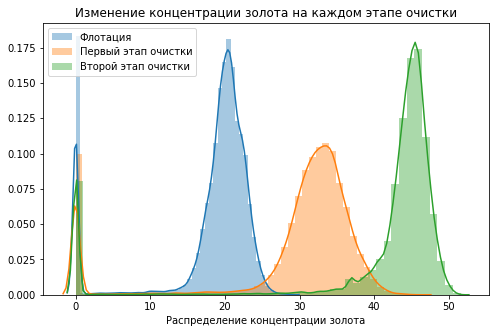

In [21]:
# Построим график изменения концентрации золота на каждом этапе очистки
plt.figure(figsize=(8,5))
ax = sns.distplot(gold_recovery_full['rougher.output.concentrate_au'], label='Флотация')
ax = sns.distplot(gold_recovery_full['primary_cleaner.output.concentrate_au'], label='Первый этап очистки')
ax = sns.distplot(gold_recovery_full['final.output.concentrate_au'], label='Второй этап очистки')
plt.legend()
ax.set(xlabel='Распределение концeнтрации золота', title='Изменение концентрации золота на каждом этапе очистки')
plt.show()

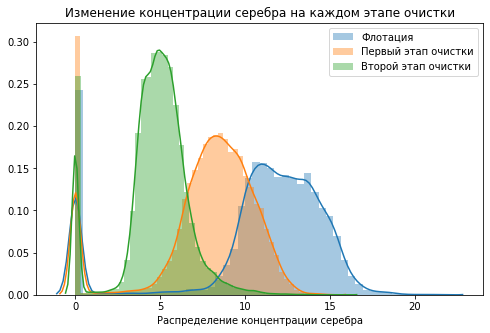

In [22]:
# Построим график изменения концентрации серебра на каждом этапе очистки
plt.figure(figsize=(8,5))
ax = sns.distplot(gold_recovery_full['rougher.output.concentrate_ag'], label='Флотация')
ax = sns.distplot(gold_recovery_full['primary_cleaner.output.concentrate_ag'], label='Первый этап очистки')
ax = sns.distplot(gold_recovery_full['final.output.concentrate_ag'], label='Второй этап очистки')
plt.legend()
ax.set(xlabel='Распределение концeнтрации серебра', title='Изменение концентрации серебра на каждом этапе очистки')
plt.show()

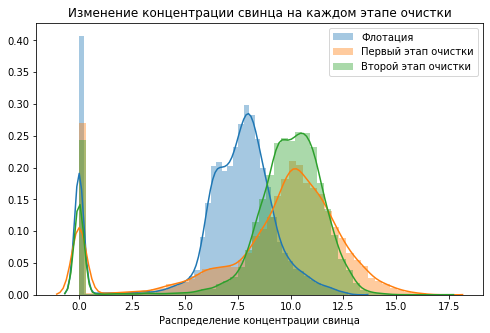

In [23]:
# Построим график изменения концентрации свинца на каждом этапе очистки
plt.figure(figsize=(8,5))
ax = sns.distplot(gold_recovery_full['rougher.output.concentrate_pb'], label='Флотация')
ax = sns.distplot(gold_recovery_full['primary_cleaner.output.concentrate_pb'], label='Первый этап очистки')
ax = sns.distplot(gold_recovery_full['final.output.concentrate_pb'], label='Второй этап очистки')
plt.legend()
ax.set(xlabel='Распределение концeнтрации свинца', title='Изменение концентрации свинца на каждом этапе очистки')
plt.show()

Как видно из представленных распределений, концентрация золота растет с увеличением степени очистки. Концентрации серебра и свинца при этом снижаются.

Также видно определенное количество выбросов в окрестности нулевой концентрации каждого компонента.

<a href='#top'>Back to top</a>

<a id='section_2_2'></a>
### 2.2. Распределение размеров гранул сырья на обучающей и тестовой выборках

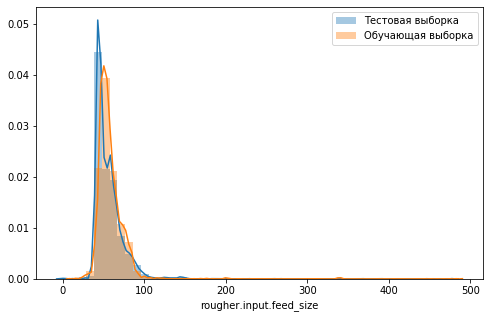

In [24]:
plt.figure(figsize=(8,5))
sns.distplot(gold_recovery_test['rougher.input.feed_size'], label='Тестовая выборка')
sns.distplot(gold_recovery_train['rougher.input.feed_size'], label='Обучающая выборка')
plt.legend()

Распределения не отличаются друг от друга, оценка модели будет правильной.

<a href='#top'>Back to top</a>

<a id='section_2_3'></a>
### 2.3. Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Обработка аномальных значений в суммарном распределении

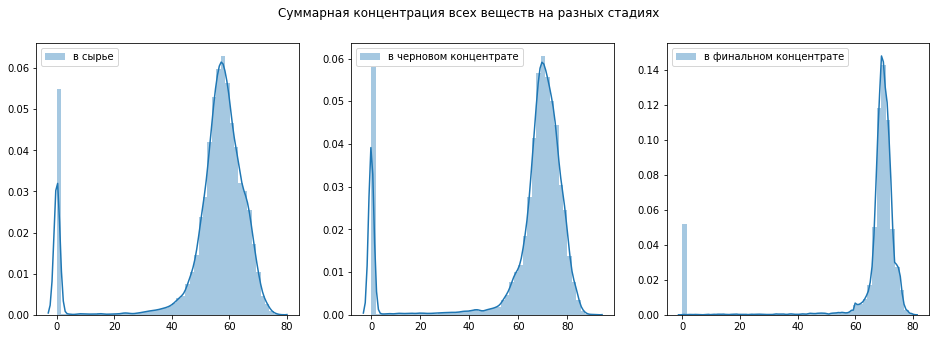

In [25]:
# Построим графики суммарной концентрации веществ на разных стадиях
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

full_sum_rougher_input = gold_recovery_full['rougher.input.feed_au'] + gold_recovery_full['rougher.input.feed_ag'] + gold_recovery_full['rougher.input.feed_pb'] + gold_recovery_full['rougher.input.feed_sol']
full_sum_rougher_output = gold_recovery_full['rougher.output.concentrate_au'] + gold_recovery_full['rougher.output.concentrate_ag'] + gold_recovery_full['rougher.output.concentrate_pb'] + gold_recovery_full['rougher.output.concentrate_sol']
full_sum_final_output = gold_recovery_full['final.output.concentrate_au'] + gold_recovery_full['final.output.concentrate_ag'] + gold_recovery_full['final.output.concentrate_pb'] + gold_recovery_full['final.output.concentrate_sol']

sns.distplot(full_sum_rougher_input, ax=ax1, label='в сырье')
sns.distplot(full_sum_rougher_output, ax=ax2, label='в черновом концентрате')
sns.distplot(full_sum_final_output, ax=ax3, label='в финальном концентрате')

fig.suptitle('Суммарная концентрация всех веществ на разных стадиях', fontsize=12)

ax1.legend()
ax2.legend()
ax3.legend()

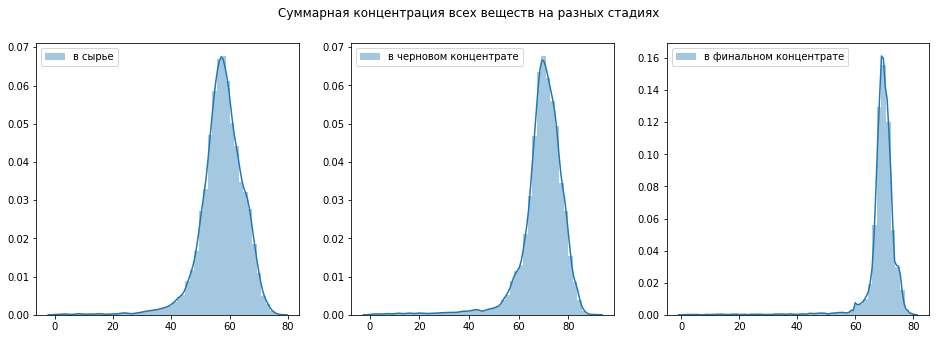

In [26]:
# Избавимся от аномальных значений в окрестности 0
full_sum_rougher_input = full_sum_rougher_input[full_sum_rougher_input > 0.1]
full_sum_rougher_output = full_sum_rougher_output[full_sum_rougher_output > 0.1]
full_sum_final_output = full_sum_final_output[full_sum_final_output > 0.1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

sns.distplot(full_sum_rougher_input, ax=ax1, label='в сырье')
sns.distplot(full_sum_rougher_output, ax=ax2, label='в черновом концентрате')
sns.distplot(full_sum_final_output, ax=ax3, label='в финальном концентрате')

fig.suptitle('Суммарная концентрация всех веществ на разных стадиях', fontsize=12)

ax1.legend()
ax2.legend()
ax3.legend()

К стадии получения финального концентрата суммарная концентрация веществ снижается.

Аномальные значения в окрестности нуля исключены из выборки для обеспечения лучшего качества модели на следующем этапе.

<a href='#top'>Back to top</a>

<a id='section_3'></a>
# 3. Модель

<a id='section_3_1'></a>
### 3.1. Функция для вычисления итоговой метрики качества sMAPE
sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»)

<p style="text-align: center;">
$\text{sMAPE} = \frac{1}{N}\cdot\sum_{i=1}^{N}\frac{|y_i - \widehat{y}_i|}{(|y_i| + |\widehat{y}_i|)\div2}\cdot\text{100%}$
</p>

<p style="text-align: center;">
$\text{Итоговое sMAPE} = \text{25%}\cdot\text{sMAPE(сырье)}+\text{75%}\cdot\text{sMAPE(финальный концентрат)}$
</p>

In [27]:
def smape(y_target, y_pred):
    return ((1/len(y_target)) * np.sum(2 * np.abs(y_target - y_pred) / (np.abs(y_target) + np.abs(y_pred)))) * 100

def final_smape(smape_rougher, smape_final):
    return 0.25*smape_rougher + 0.75*smape_final

<a href='#top'>Back to top</a>

<a id='section_3_2'></a>
### 3.2. Обучение и оценка качества моделей кросс-валидацией. Выбор лучшей модели

In [28]:
# Подготовим данные по сырью
features_train_rougher = gold_recovery_train.set_index('date')
features_test_rougher = gold_recovery_test.set_index('date')
target_train_rougher = gold_recovery_full.set_index('date').loc[list(gold_recovery_train.set_index('date').index), 'rougher.output.recovery']
target_test_rougher = gold_recovery_full.set_index('date').loc[list(gold_recovery_test.set_index('date').index), 'rougher.output.recovery']

# Подготовим данные по финальному концентрату
features_train_final = gold_recovery_train.set_index('date')
features_test_final = gold_recovery_test.set_index('date')
target_train_final = gold_recovery_full.set_index('date').loc[list(gold_recovery_train.set_index('date').index), 'final.output.recovery']
target_test_final = gold_recovery_full.set_index('date').loc[list(gold_recovery_test.set_index('date').index), 'final.output.recovery']

# Заполним оставшиеся пропуски в данных средними значениями
target_train_final = target_train_final.fillna(target_train_final.mean())
target_train_rougher = target_train_rougher.fillna(target_train_rougher.mean())

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [29]:
print(features_train_rougher.shape, features_train_final.shape)
print(features_test_rougher.shape, features_test_final.shape)
print(target_train_rougher.shape, target_train_final.shape)
print(target_test_rougher.shape, target_test_final.shape)

(13522, 52) (13522, 52)
(5383, 52) (5383, 52)
(13522,) (13522,)
(5383,) (5383,)


<a href='#top'>Back to top</a>

<a id='section_3_2_1'></a>
### Поиск лучших параметров для тестовой выборки по сырью
#### Случайный лес

In [30]:
# Посмотрим на список параметров
RandomForestRegressor().get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [31]:
# Проведем кросс-валидацию с помощью kFold с делением на 5 частей
cv = KFold(n_splits=5, shuffle=False)

# Выберем параметры для подбора оптимальных с GridSearchCV
param_grid = [
    {
        'n_estimators': [10, 20, 30],
        'max_depth': [2, 4]
    }
]

# Проведем подбор оптимальных параметров с GridSearchCV
smape_score = make_scorer(smape, greater_is_better=False)
grid_rougher = GridSearchCV(estimator=RandomForestRegressor(random_state=rnd_state), param_grid=param_grid, cv=cv, n_jobs=-1, scoring=smape_score)
grid_rougher.fit(features_train_rougher, target_train_rougher)
print(grid_rougher.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=260686,
                      verbose=0, warm_start=False)


In [32]:
#Вывод лучших подобранных параметров RandomForestRegressor для тестовой выборки по сырью
print('Best parameters for RandomForestRegressor:', grid_rougher.best_params_)
print('Best sMAPE score:', -grid_rougher.best_score_)

Best parameters for RandomForestRegressor: {'max_depth': 4, 'n_estimators': 30}
Best sMAPE score: 10.231367004548744


#### Линейная регрессия

In [33]:
# Посмотрим на список параметров
LinearRegression().get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [34]:
# Проведем кросс-валидацию с помощью kFold с делением на 5 частей
cv = KFold(n_splits=5, shuffle=False)

# Выберем параметры для подбора оптимальных с GridSearchCV
param_grid = [
    {
        'copy_X': [True, False],
        'fit_intercept': [True, False]
    }
]

# Проведем подбор оптимальных параметров с GridSearchCV
smape_score = make_scorer(smape)
grid_rougher = GridSearchCV(estimator=LinearRegression(), param_grid=param_grid, cv=cv, n_jobs=-1, scoring=smape_score)
grid_rougher.fit(features_train_rougher, target_train_rougher)
print(grid_rougher.best_estimator_)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)


In [35]:
#Вывод лучших подобранных параметров LinearRegression для тестовой выборки по сырью
print('Best parameters for LinearRegression:', grid_rougher.best_params_)
print('Best sMAPE score:', grid_rougher.best_score_)

Best parameters for LinearRegression: {'copy_X': True, 'fit_intercept': False}
Best sMAPE score: 10.800201768015215


Исходя из расчета sMAPE для тестовой выборки по сырью, лучшие параметры у модели случайного леса с числом деревьев - 30 и глубиной - 4.

<a href='#top'>Back to top</a>

<a id='section_3_2_2'></a>
### Поиск лучших параметров для тестовой выборки по финальному концентрату
#### Случайный лес

In [36]:
# Проведем кросс-валидацию с помощью kFold с делением на 5 частей
cv = KFold(n_splits=5, shuffle=False)

# Выберем параметры для подбора оптимальных с GridSearchCV
param_grid = [
    {
        'n_estimators': [10, 20, 30],
        'max_depth': [2, 4]
    }
]

# Проведем подбор оптимальных параметров с GridSearchCV
smape_score = make_scorer(smape)
grid_final = GridSearchCV(estimator=RandomForestRegressor(random_state=rnd_state), param_grid=param_grid, cv=cv, n_jobs=-1, scoring=smape_score)
grid_final.fit(features_train_final, target_train_final)
print(grid_final.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=260686,
                      verbose=0, warm_start=False)


In [37]:
#Вывод лучших подобранных параметров RandomForestRegressor для тестовой выборки по финальному концентрату
print('Best parameters for RandomForestRegressor:', grid_final.best_params_)
print('Best sMAPE score:', grid_final.best_score_)

Best parameters for RandomForestRegressor: {'max_depth': 4, 'n_estimators': 20}
Best sMAPE score: 9.287630040197236


#### Линейная регрессия

In [38]:
# Проведем кросс-валидацию с помощью kFold с делением на 5 частей
cv = KFold(n_splits=5, shuffle=False)

# Выберем параметры для подбора оптимальных с GridSearchCV
param_grid = [
    {
        'copy_X': [True, False],
        'fit_intercept': [True, False]
    }
]

# Проведем подбор оптимальных параметров с GridSearchCV
smape_score = make_scorer(smape)
grid_final = GridSearchCV(estimator=LinearRegression(), param_grid=param_grid, cv=cv, n_jobs=-1, scoring=smape_score)
grid_final.fit(features_train_final, target_train_final)
print(grid_final.best_estimator_)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)


In [39]:
#Вывод лучших подобранных параметров LinearRegression для тестовой выборки по финальному концентрату
print('Best parameters for LinearRegression:', grid_final.best_params_)
print('Best sMAPE score:', grid_final.best_score_)

Best parameters for LinearRegression: {'copy_X': True, 'fit_intercept': False}
Best sMAPE score: 10.502924029921198


Исходя из расчета sMAPE для тестовой выборки по финальному концентрату, лучшие параметры у модели случайного леса с числом деревьев - 20 и глубиной - 4.

In [40]:
# Модель с лучшими параметрами для тестовой выборки по сырью
model = RandomForestRegressor(n_estimators=30, max_depth=4, random_state=rnd_state)
model.fit(features_train_rougher, target_train_rougher)
predicted_valid = model.predict(features_test_rougher)
smape_rougher = smape(target_test_rougher, predicted_valid)
print(f'sMAPE для тестовой выборки по сырью: {smape_rougher}')

sMAPE для тестовой выборки по сырью: 9.534345758821893


In [41]:
# Модель с лучшими параметрами для тестовой выборки по финальному концентрату
model = RandomForestRegressor(n_estimators=20, max_depth=4, random_state=rnd_state)
model.fit(features_train_final, target_train_final)
predicted_valid = model.predict(features_test_final)
smape_final = smape(target_test_final, predicted_valid)
print(f'sMAPE для тестовой выборки по финальному концентрату: {smape_final}')

sMAPE для тестовой выборки по финальному концентрату: 8.903417076259611


In [42]:
# Итоговый sMAPE 
final_smape(smape_rougher, smape_final)

9.061149246900182

<a id='section_4'></a>
## Общий вывод
* Вычислили эффективность обогащения на обучающей выборке для признака `rougher.output.recovery`. Исходя из полученных результатов, увидели, что средняя абсолютная ошибка минимальна и составляет $ 8*10^{-15} $. Расчеты верны
* Были удалены лишние признаки в обучающей выборке, отличающиеся от тестовой. Удалены пустые строки в обеих выборках. В обучающей и тестовой выборках перед этапом машинного обучения по 53 признака, а также по 13522 и 5383 объектов соответственно. После вывода значений даты/времени в качестве индекса в обучении участвовало 52 признака
* Построив распределения, увидели, что концентрация золота растет с увеличением степени очистки. Концентрации серебра и свинца при этом снижаются. Также было отмечено определенное количество выбросов в окрестности нулевой концентрации каждого компонента, которые были удалены для улучшения качества модели
* Модель случайного леса показала наилучший результат по параметру sMAPE после подбора оптимальных параметров c помощью GridSearchCV
* Итоговое sMAPE для модели случайного леса составило 9.06

<a href='#top'>Back to top</a>